
Loading images from category: spidermite and subfolder: Tomato__spidermite
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categories.
Loading images from category: healthy and subfolder: Tomato___healthy
Loading images from category: lateblight and subfolder: Tomato___Lateblight
Loading images from category: leafmold and subfolder: Tomato___Leafmold
Loading images from category: septorialeafspot and subfolder: Tomato___Septorialeafspot
Category: targetspot from subfolder Tomato___Targetspot is not in the list of categories.
Loading images from category: mosaicvirus and subfolder: Tomato___Tomato_mosaicvirus
Loading images from category: yellowleafcurlvirus and subfolder: Tomato___Tomato_yellowleafcurlvirus
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of catego

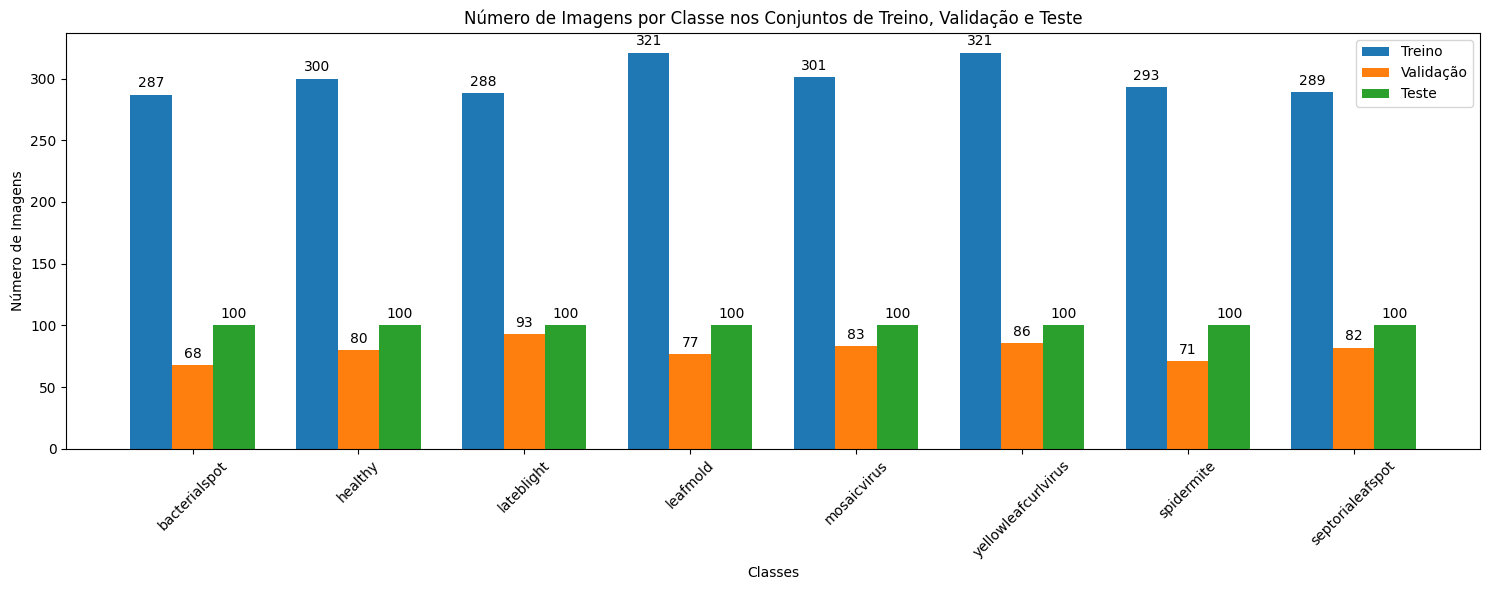

In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from utils.duarte_utils import DuarteUtils

train_dir = "..\isec-ic\\dataset\\train"
validation_dir = "..\isec-ic\\dataset\\valid"
test_dir = "..\isec-ic\\dataset\\test"

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))
train_dir = os.path.join(current_dir, train_dir)
validation_dir = os.path.join(current_dir, validation_dir)
test_dir = os.path.join(current_dir, test_dir)

categories = ["bacterialspot", "healthy","lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot" ]

def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder)
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64))
                img = np.array(img) / 255.0
                images.append(img)
                labels.append(categories.index(category))
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")
    return np.array(images), np.array(labels)


x_train, y_train = load_images_from_folder(train_dir)
x_validation, y_validation = load_images_from_folder(validation_dir)
x_test, y_test = load_images_from_folder(test_dir)

print("Images loaded successfully")


reduction_ratio = 0.8

x_validation, x_reduction_validation, y_validation, y_reduction_validation = train_test_split(x_validation, y_validation, test_size=reduction_ratio, random_state=42)
print("Conjunto de validação reduzido em 80%")

x_train, x_reduction, y_train, y_reduction = train_test_split(x_train, y_train, test_size=reduction_ratio, random_state=42)
print("Conjunto de treino reduzido em 80%")




DuarteUtils.display_folder_distributions(y_train, y_validation, y_test, categories)


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Função para criar o modelo CNN
def create_cnn_model(dropout_rate, learning_rate):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(len(categories), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print(" defined cnn model function")

 defined cnn model function


In [3]:
import os
import psutil

# Define a função para limitar a afinidade do processador
def limitar_afinidade(processo, num_cores):
    if num_cores < 1:
        num_cores = 1
    elif num_cores > psutil.cpu_count(logical=False):
        num_cores = psutil.cpu_count(logical=False)

    processo.cpu_affinity(list(range(num_cores)))

# Obtém o ID do processo atual
pid = os.getpid()

# Define o número de núcleos desejado (metade dos núcleos disponíveis)
metade_dos_cores = psutil.cpu_count(logical=False) // 3

# Limita a afinidade do processador
limitar_afinidade(psutil.Process(pid), metade_dos_cores)

# Restaura a afinidade do processador para todos os núcleos após a execução do código
limitar_afinidade(psutil.Process(pid), psutil.cpu_count(logical=False))

if tf.test.is_gpu_available():
    print("GPU disponível. Usando GPU para treinamento.")
else:
    print("GPU não disponível. Usando CPU para treinamento.")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU disponível. Usando GPU para treinamento.


In [7]:
import numpy as np
import random
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score

k_n_splits=3
n_iterations= 20
total_epochs = 5

def evaluate_model_cv(dropout_rate, learning_rate, x_train, y_train, n_splits=5):
    print(f" - Evaluating with cross validation, splits={n_splits}")
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    auc_scores = []

    for train_index, val_index in kfold.split(x_train):
        model = create_cnn_model(dropout_rate, learning_rate)
        model.fit(x_train[train_index], y_train[train_index], epochs=total_epochs, batch_size=32, verbose=1)
        
        y_pred = model.predict(x_train[val_index])
        y_val_categorical = to_categorical(y_train[val_index], num_classes=len(categories))
        auc_score = roc_auc_score(y_val_categorical, y_pred, multi_class='ovr')
        auc_scores.append(auc_score)

    return np.mean(auc_scores)

def random_search(x_train, y_train, n_iter=100):
    best_score = -np.inf
    best_params = {'dropout_rate': None, 'learning_rate': None}
    best_auc_score = None
    
    for _ in range(n_iter):
        dropout_rate = abs(random.uniform(0.1, 0.99))
        learning_rate = abs(random.uniform(0.0001, 0.01))
        print(f"Testing params:  dropout_rate: {dropout_rate}, learning_rate: {learning_rate}")
        auc_score = evaluate_model_cv(dropout_rate, learning_rate, x_train, y_train, k_n_splits)

        if auc_score > best_score:
            best_score = auc_score
            best_params = {'dropout_rate': dropout_rate, 'learning_rate': learning_rate}
            best_auc_score = auc_score
            print(f"New best score: AUC={auc_score}, with parameters: dropout_rate={dropout_rate}, learning_rate={learning_rate}")

    return best_params, best_auc_score
    
best_params, best_auc_score = random_search(x_train, y_train, n_iter=n_iterations)
print(f"Melhores parâmetros encontrados: {best_params}, Melhor pontuação AUC: {best_auc_score}")

Testing params:  dropout_rate: 0.8489557848437064, learning_rate: 0.0007776211456043132
 - Evaluating with cross validation, splits=3
Epoch 1/5
50/50 [==============================] - 1s 5ms/step - loss: 2.8073 - accuracy: 0.1641
Epoch 2/5
50/50 [==============================] - 0s 4ms/step - loss: 1.6901 - accuracy: 0.3785
Epoch 3/5
50/50 [==============================] - 0s 5ms/step - loss: 1.4388 - accuracy: 0.5052
Epoch 4/5
50/50 [==============================] - 0s 5ms/step - loss: 1.3233 - accuracy: 0.5321
Epoch 5/5
50/50 [==============================] - 0s 4ms/step - loss: 1.2055 - accuracy: 0.5823
Epoch 1/5
50/50 [==============================] - 0s 5ms/step - loss: 2.6906 - accuracy: 0.1662
Epoch 2/5
50/50 [==============================] - 0s 5ms/step - loss: 1.6570 - accuracy: 0.3980
Epoch 3/5
50/50 [==============================] - 0s 4ms/step - loss: 1.4683 - accuracy: 0.4841
Epoch 4/5
50/50 [==============================] - 0s 5ms/step - loss: 1.3309 - accuracy: 

In [ ]:
best_learning_rate = random_search_result.best_params_["learning_rate"]
best_dropout_rate = random_search_result.best_params_["dropout_rate"]

print("Treinando o modelo com os melhores hiperparâmetros...")
best_model = create_cnn_model(best_dropout_rate, best_learning_rate)
best_model_history = best_model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(x_validation, y_validation))

best_train_accuracy = best_model_history.history['accuracy'][-1]
best_validation_accuracy = best_model_history.history['val_accuracy'][-1]

print("Melhor Accuracy de Treino:", best_train_accuracy)
print("Melhor Accuracy de Validação:", best_validation_accuracy)

import matplotlib.pyplot as plt

# Plotar as curvas de treino e validação
plt.plot(best_model_history.history['accuracy'], label='Treinamento')
plt.plot(best_model_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
print("Avaliando o modelo no conjunto de teste...")
loss_test, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)

print(f"Acurácia no Teste: {test_accuracy}, Loss: {loss_test}")